# Exploratory Data Analysis
In this notebook, we explore our enzyme-substrate dataset, covering:
1. Plot of EC classes in our dataset
2. 2-dimensional t-SNE plot of ESM-1b representations of enzymes

### Import Packages

In [2]:
# General
import os
from os.path import join
import pickle

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Data wrangling
import pandas as pd
from objects import Dataset

In [19]:
# Read in datasets
CURRENT_DIR = os.getcwd()
substrates_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'substrates_df.pkl'))
enzyme_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'enzyme_df_sequences.pkl'))

## EC Class Plots

In [64]:
def grab_first(string):
    """
    Get first character of a string and convert it to integer

    Parameters:
    (1) string - string to get first character of (string)

    Returns:
    (1) first - first character in string converted to integer (integer)
    """
    first = int(string[0])
    return first

# Create mapping of EC class to class name
class_mapping = {
    1: 'Oxidoreductases (1)',
    2: 'Transferases (2)',
    3: 'Hydrolases (3)',
    4: 'Lyases (4)',
    5: 'Isomerases (5)',
    6: 'Ligases (6)',
    7: 'Translocases (7)'
}

# Create column of EC class of each enzyme by taking first number in every EC number, then apply mapping to class name
enzyme_df['ec'] = enzyme_df['ec_number'].apply(grab_first).map(class_mapping)

<Axes: title={'center': 'Number of Enzymes per EC Class'}, xlabel='EC Class', ylabel='Enzymes'>

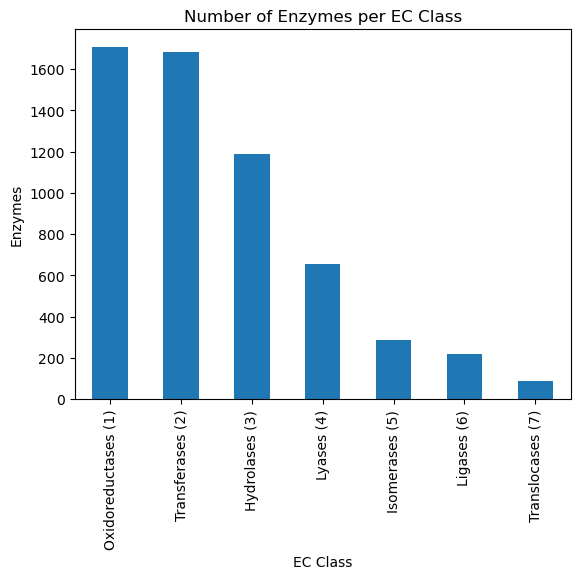

In [66]:
# Grouping by EC class, show count of enzymes in each class
ec_counts = enzyme_df.groupby('ec').count()['ec_number']
# Sort the counts in descending order
sorted_ec_counts = ec_counts.sort_values(ascending=False)
# Plot the sorted data
sorted_ec_counts.plot(kind='bar', ylabel='Enzymes', xlabel='EC Class', title='Number of Enzymes per EC Class')

<Axes: title={'center': 'Number of Substrates Catalysed per EC Class'}, xlabel='EC Class', ylabel='Total Substrates Catalysed'>

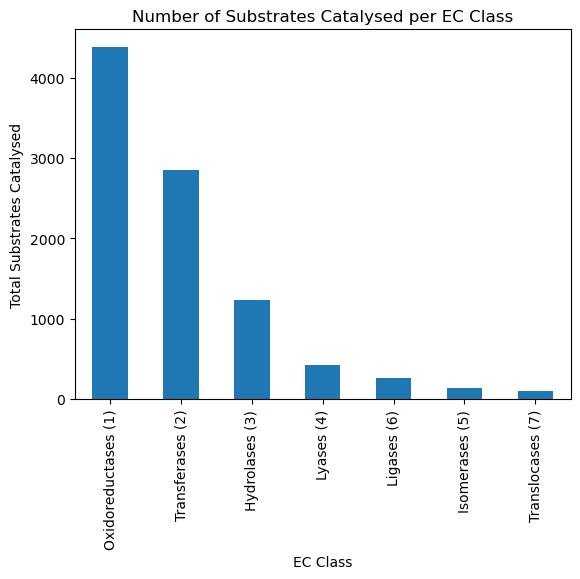

In [68]:
# Create column of EC class of each enzyme by taking first number in every EC number
substrates_df['ec'] = substrates_df['ec_number'].apply(grab_first).map(class_mapping)
# Grouping by EC class show aggregate count of substrates catalysed by each enzyme class
ec_counts = substrates_df.groupby('ec').count()['ec_number']
# Sort the counts in descending order
sorted_ec_counts = ec_counts.sort_values(ascending=False)
# Plot the sorted data
sorted_ec_counts.plot(kind='bar', ylabel='Total Substrates Catalysed', xlabel='EC Class', title='Number of Substrates Catalysed per EC Class')

### ESM-1b Representations Plot

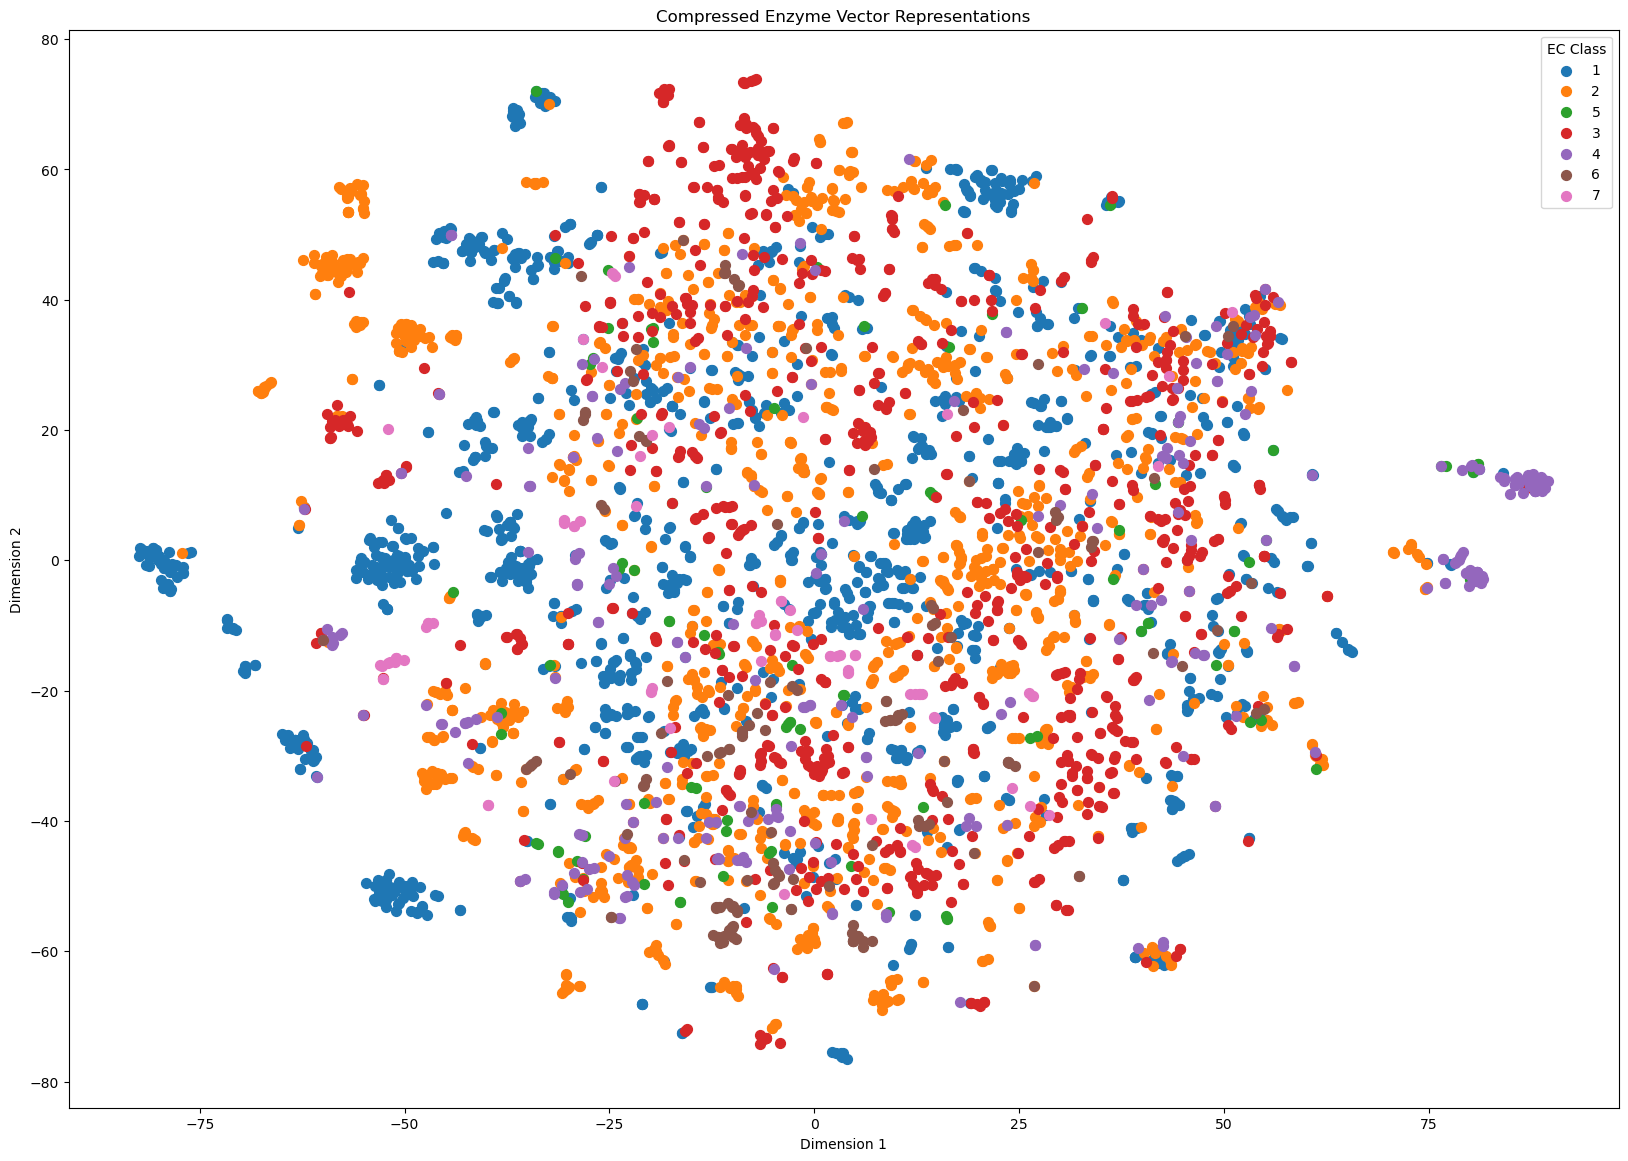

In [18]:
# Instantiate Dataset object from enzyme-substrate dataset
data = Dataset(substrates_df)
# Featurise enzyme representations, creating a column for every value in the ESM-1b representations
featurised = data.featurise_df('enzyme', 'ESM1b')

# Get EC classes for each enzyme by merging with previously augmented dataset
enzymes = featurised.merge(right = enzyme_df, left_on = 'enzyme', right_on = 'enzyme', how = 'left').drop(columns = ['ec_number', 'systematic_name', 'reaction_type', 'substrates', 'products', 'sequence', 'enzyme', 'ESM1b', 'ESM2']).reset_index(drop=True)

# Create feature and label dataframes
X = enzymes.iloc[:, :1280]
y = enzymes.iloc[:, 1280]

# Instantiate TSNE object
tsne = TSNE(n_components=2)
# Transform dataset with t-SNE
transformed = tsne.fit_transform(X)

# Create a new dataframe with the newly transformed data
transformed_df = pd.DataFrame(data=transformed, columns=['TSNE_1', 'TNSE_2'])

# Add the label column to our dataset for the labels
transformed_df['colour'] = y

# Create a list of the distinct EC classes, so we can customise the colour palette used in the visualisation
unique_classes = transformed_df['colour'].unique()
num_classes = len(unique_classes)
palette = sns.color_palette("tab10", num_classes)

# Plotting the scatter plot
plt.figure(figsize=(20, 14))

# Plot each EC class with a different color
for i, unique_class in enumerate(unique_classes):
    subset = transformed_df[transformed_df['colour'] == unique_class]
    plt.scatter(subset['TSNE_1'], subset['TNSE_2'], 
                s=50, label=unique_class, color=palette[i])

# Set titles and axes
plt.title('Compressed Enzyme Vector Representations')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='EC Class')
plt.show()